# Statistical tests for "Silicone: an open-source Python package for inferring missing emissions data for climate change research"
This notebook is where results not generated by the silicone package itself were calculated. 

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations

In [2]:
CO2_results_orig = pd.read_csv("../input/CruncherComparisonLead_CO2.csv", index_col=0)
CH4_results_orig = pd.read_csv("../input/CruncherComparisonLead_CH4.csv", index_col=0)

## Calculating the difference between infilling with CO2 and CH4 emissions
We can't compare the values with CO2 or CH4 itself, so remove them. 

In [3]:
to_drop = ["Emissions|CO2", "Emissions|CH4"]
CO2_results = CO2_results_orig.drop(to_drop, errors="ignore")
CH4_results = CH4_results_orig.drop(to_drop, errors="ignore")

In [4]:
difference_res = (CO2_results - CH4_results)
difference_res

,QuantileRollingWindows,RMSClosest,LinearInterpolation,EqualQuantileWalk
Emissions|BC,0.001082,0.003908,0.008356,0.006009
Emissions|CO,0.001044,0.021310,0.005379,-0.002127
Emissions|F-Gases,-0.005316,-0.004709,-0.006543,-0.011260
Emissions|HFC,-0.010724,0.011296,-0.017329,-0.018573
Emissions|N2O,0.032117,0.029422,0.051840,0.059061
Emissions|NH3,0.005295,0.032770,0.026440,0.001498
Emissions|NOx,-0.003443,-0.003901,0.000387,0.001834
Emissions|OC,0.002656,0.021998,0.017794,0.022770
Emissions|PFC,0.010144,0.035372,0.012306,0.008392
Emissions|SF6,0.005139,-0.001192,-0.001571,0.003733


(array([ 4.,  3., 10., 10.,  2.,  5.,  8.,  3.,  2.,  1.]),
 array([0.06206453, 0.0797344 , 0.09740427, 0.11507414, 0.13274401,
        0.15041388, 0.16808375, 0.18575362, 0.20342349, 0.22109336,
        0.23876323]),
 <a list of 10 Patch objects>)

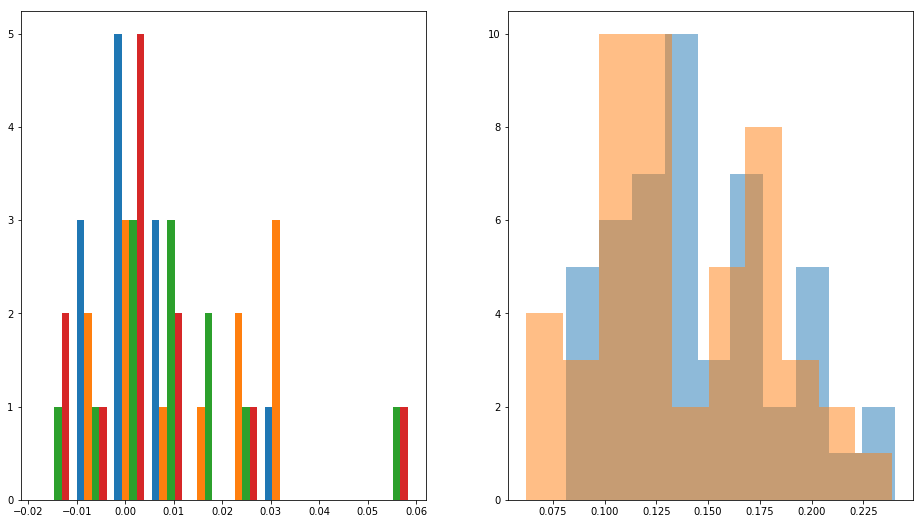

In [5]:
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(121)
plt.hist(difference_res.values)
ax = plt.subplot(122)
plt.hist(CO2_results.values.ravel(), alpha = 0.5)
plt.hist(CH4_results.values.ravel(), alpha = 0.5)

In [6]:
# Calculate the t-test statistics for each cruncher
stats.ttest_rel(CO2_results.values, CH4_results.values)

Ttest_relResult(statistic=array([1.02320263, 3.11892134, 1.93877008, 0.93077944]), pvalue=array([0.32818794, 0.00976877, 0.07860579, 0.37194494]))

In [7]:
# Calculate the t-test statistics for all data together
stats.ttest_rel(CO2_results.values.ravel(), CH4_results.values.ravel())

Ttest_relResult(statistic=3.4193737300660745, pvalue=0.0013067333626455874)

# Calculating the difference between crunchers

In [9]:
all_results = CO2_results_orig.append(CH4_results_orig)
all_results

,QuantileRollingWindows,RMSClosest,LinearInterpolation,EqualQuantileWalk
Emissions|BC,0.129157,0.118940,0.176855,0.161039
Emissions|CH4,0.085871,0.072788,0.096929,0.093807
Emissions|CO,0.140090,0.133444,0.182223,0.175247
Emissions|F-Gases,0.106261,0.094665,0.125233,0.118164
Emissions|HFC,0.152433,0.140330,0.165032,0.159283
Emissions|N2O,0.110363,0.091487,0.136481,0.134480
Emissions|NH3,0.174929,0.151405,0.239547,0.240262
Emissions|NOx,0.103714,0.094937,0.131779,0.120640
Emissions|OC,0.144260,0.128828,0.196234,0.202308
Emissions|PFC,0.132374,0.100929,0.119947,0.162719


In [23]:
results_all = []
results_CO2 = []
results_CH4 = []
column_combo = combinations(all_results.columns, 2)
for col1, col2 in column_combo:
    results_all.append([col1, col2, stats.ttest_rel(all_results[col1], all_results[col2]).pvalue])
    results_CO2.append([col1, col2, stats.ttest_rel(CO2_results_orig[col1], CO2_results_orig[col2]).pvalue])
    results_CH4.append([col1, col2, stats.ttest_rel(CH4_results_orig[col1], CH4_results_orig[col2]).pvalue])

In [21]:
results_all

[['QuantileRollingWindows', 'RMSClosest', 3.052133012230844e-08],
 ['QuantileRollingWindows', 'LinearInterpolation', 1.548027528452534e-07],
 ['QuantileRollingWindows', 'EqualQuantileWalk', 9.291247398054141e-08],
 ['RMSClosest', 'LinearInterpolation', 4.229397360535865e-11],
 ['RMSClosest', 'EqualQuantileWalk', 6.597777415431516e-09],
 ['LinearInterpolation', 'EqualQuantileWalk', 0.6119262485421693]]

In [24]:
results_CH4

[['QuantileRollingWindows', 'RMSClosest', 0.00010381623682828899],
 ['QuantileRollingWindows', 'LinearInterpolation', 0.0002669872373789759],
 ['QuantileRollingWindows', 'EqualQuantileWalk', 0.00050529920779666],
 ['RMSClosest', 'LinearInterpolation', 5.837249331609981e-06],
 ['RMSClosest', 'EqualQuantileWalk', 0.00013815528403625854],
 ['LinearInterpolation', 'EqualQuantileWalk', 0.5171572129869282]]

In [25]:
results_CO2

[['QuantileRollingWindows', 'RMSClosest', 2.9589595165785068e-05],
 ['QuantileRollingWindows', 'LinearInterpolation', 0.0002751529198166419],
 ['QuantileRollingWindows', 'EqualQuantileWalk', 0.00011145561087452433],
 ['RMSClosest', 'LinearInterpolation', 5.71229517722896e-06],
 ['RMSClosest', 'EqualQuantileWalk', 1.709964278032949e-05],
 ['LinearInterpolation', 'EqualQuantileWalk', 0.9896697093945696]]

In [22]:
all_results.mean()

QuantileRollingWindows    0.129873
RMSClosest                0.107978
LinearInterpolation       0.156271
EqualQuantileWalk         0.157880
dtype: float64